    Topic: Challenge Set 1
    Subject: Explore MTA turnstile data 
    Date: 07/06/2018 
    Name: Jessica Hudiono

In [162]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import requests

from datetime import date
from datetime import datetime
from io import StringIO
from matplotlib.pyplot import figure
from matplotlib.dates import DayLocator
from matplotlib.dates import DateFormatter

%matplotlib inline

## Question 1

In [148]:
def url_to_dataframe(url):
    print("Reading", url)
    df = pd.read_csv(
        StringIO(requests.get(url).content.decode('utf8')),
        usecols=(lambda c: c not in ['LINENAME', 'DIVISION', 'DESC'])
        # Don't need LINENAME, DIVISION, DESC for the challenge questions
    )
    df.columns = [column.strip() for column in df.columns]
    return df

df = url_to_dataframe("http://web.mta.info/developers/data/nyct/turnstile/turnstile_180630.txt")
df.sample(10)

Reading http://web.mta.info/developers/data/nyct/turnstile/turnstile_180630.txt


,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS
79044,N324,R018,00-00-04,JKSN HT-ROOSVLT,06/29/2018,20:00:00,2425413,1641157
194677,R729,R292,00-00-00,BAYCHESTER AV,06/23/2018,13:00:00,1091530,353833
131803,R148,R033,01-00-01,TIMES SQ-42 ST,06/29/2018,04:00:00,1892563258,1427892616
59802,N103,R127,00-06-01,JAY ST-METROTEC,06/29/2018,16:00:00,6290170,1702197
70705,N212,R253,01-06-00,174-175 STS,06/25/2018,20:00:00,33605208,486584847
176870,R514,R094,00-03-00,ASTORIA BLVD,06/29/2018,12:00:00,16662289,3387437
107692,N700,R570,00-03-02,72 ST-2 AVE,06/29/2018,01:00:00,1322124,767022
59656,N103,R127,00-03-00,JAY ST-METROTEC,06/26/2018,08:00:00,458817,0
106930,N606,R025,00-05-00,JAMAICA CENTER,06/28/2018,00:00:00,7082,0
160150,R262A,R195,04-00-05,161/YANKEE STAD,06/27/2018,04:22:00,80226,62118


In [4]:
df.columns = [column.strip() for column in df.columns]

## Question 2
Combine date and time into a new datetime column.

In [5]:
df['DATETIME_STR'] = df['DATE'] + " " + df['TIME']
df['DATETIME'] = pd.to_datetime(df["DATETIME_STR"], infer_datetime_format=True)
df.drop(columns=["DATETIME_STR"], inplace=True)

print(df['DATETIME'].dtype)
df.sample(10)

datetime64[ns]


,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,DATETIME
107222,N607,R025,01-06-00,JAMAICA CENTER,06/27/2018,16:00:00,56244,13828,2018-06-27 16:00:00
55955,N092,R029,03-00-05,CHAMBERS ST,06/25/2018,04:00:00,2490276,1204535,2018-06-25 04:00:00
140453,R186,R036,00-05-00,DYCKMAN ST,06/23/2018,12:00:00,1375,0,2018-06-23 12:00:00
139081,R177,R273,01-00-02,145 ST,06/25/2018,20:00:00,3320709,7767638,2018-06-25 20:00:00
39349,J035,R008,00-00-01,111 ST,06/26/2018,04:00:00,3194028,2974668,2018-06-26 04:00:00
189476,R622,R123,00-00-05,FRANKLIN AV,06/23/2018,20:00:00,9348052,8260034,2018-06-23 20:00:00
174377,R503,R276,01-06-00,VERNON-JACKSON,06/25/2018,16:00:00,711070,742749,2018-06-25 16:00:00
90012,N418,R269,01-06-01,BEDFORD-NOSTRAN,06/25/2018,08:00:00,4628900,524850,2018-06-25 08:00:00
170041,R409,R449,01-00-02,E 149 ST,06/25/2018,05:00:00,2042151,6254220,2018-06-25 05:00:00
104921,N601A,R319,01-00-03,LEXINGTON AV/63,06/26/2018,12:00:00,63726,146781,2018-06-26 12:00:00


## Question 3
Find total daily entries for each turnstile. Each entry accounts for about n=4 hours of traffic.

In [6]:
# Confirmed that SCP id is reused for different C/A, but C/A id is unique across stations. 
assert len(df.groupby(['STATION', 'UNIT', 'C/A']).mean()) == len(df['C/A'].unique())

In [7]:
# Confirmed that each turnstile has a single unique row per datetime. 
assert len(df) == len(df.groupby(['STATION', 'UNIT', 'C/A', 'SCP', 'DATETIME']).mean())

df_hourly_mean = df.groupby(['STATION', 'UNIT', 'C/A', 'SCP', 'DATETIME']).mean()
df_hourly_sum = df.groupby(['STATION', 'UNIT', 'C/A', 'SCP', 'DATETIME']).sum()
assert df_hourly_mean.equals(df_hourly_sum)

In [8]:
# Get first and last 'ENTRIES' of the day per turnstile.
df_first = df.groupby(['STATION', 'UNIT', 'C/A', 'SCP', 'DATE']).min().reset_index()
df_first.head()

,STATION,UNIT,C/A,SCP,DATE,TIME,ENTRIES,EXITS,DATETIME
0,1 AV,R248,H007,00-00-00,06/23/2018,00:00:00,13666640,15323756,2018-06-23
1,1 AV,R248,H007,00-00-00,06/24/2018,00:00:00,13669213,15328275,2018-06-24
2,1 AV,R248,H007,00-00-00,06/25/2018,00:00:00,13672052,15331837,2018-06-25
3,1 AV,R248,H007,00-00-00,06/26/2018,00:00:00,13675737,15336054,2018-06-26
4,1 AV,R248,H007,00-00-00,06/27/2018,00:00:00,13679675,15340413,2018-06-27


In [9]:
df_last = df.groupby(['STATION', 'UNIT', 'C/A', 'SCP', 'DATE']).max().reset_index()
df_last.head()

,STATION,UNIT,C/A,SCP,DATE,TIME,ENTRIES,EXITS,DATETIME
0,1 AV,R248,H007,00-00-00,06/23/2018,20:00:00,13668772,15327477,2018-06-23 20:00:00
1,1 AV,R248,H007,00-00-00,06/24/2018,20:00:00,13671606,15331266,2018-06-24 20:00:00
2,1 AV,R248,H007,00-00-00,06/25/2018,20:00:00,13675318,15335546,2018-06-25 20:00:00
3,1 AV,R248,H007,00-00-00,06/26/2018,20:00:00,13679204,15339867,2018-06-26 20:00:00
4,1 AV,R248,H007,00-00-00,06/27/2018,20:00:00,13683213,15344084,2018-06-27 20:00:00


In [10]:
# Subtract the first 'ENTRIES' from the last 'ENTRIES' of the day to get the daily entry.
df_last['DAILY_ENTRIES'] = df_last['ENTRIES'] - df_first['ENTRIES']
df_last.head(15)

,STATION,UNIT,C/A,SCP,DATE,TIME,ENTRIES,EXITS,DATETIME,DAILY_ENTRIES
0,1 AV,R248,H007,00-00-00,06/23/2018,20:00:00,13668772,15327477,2018-06-23 20:00:00,2132
1,1 AV,R248,H007,00-00-00,06/24/2018,20:00:00,13671606,15331266,2018-06-24 20:00:00,2393
2,1 AV,R248,H007,00-00-00,06/25/2018,20:00:00,13675318,15335546,2018-06-25 20:00:00,3266
3,1 AV,R248,H007,00-00-00,06/26/2018,20:00:00,13679204,15339867,2018-06-26 20:00:00,3467
4,1 AV,R248,H007,00-00-00,06/27/2018,20:00:00,13683213,15344084,2018-06-27 20:00:00,3538
5,1 AV,R248,H007,00-00-00,06/28/2018,20:00:00,13687151,15348038,2018-06-28 20:00:00,3491
6,1 AV,R248,H007,00-00-00,06/29/2018,20:00:00,13691070,15352435,2018-06-29 20:00:00,3437
7,1 AV,R248,H007,00-00-01,06/23/2018,20:00:00,58986357,37283419,2018-06-23 20:00:00,3097
8,1 AV,R248,H007,00-00-01,06/24/2018,20:00:00,58990207,37285190,2018-06-24 20:00:00,3194
9,1 AV,R248,H007,00-00-01,06/25/2018,20:00:00,58995099,37287088,2018-06-25 20:00:00,4293


## Question 4
Plot daily time series for a turnstile. 

In [23]:
turnstile1 = ts1 = ("1 AV","R248","H007","00-00-00")
turnstile2 = ts2 = ("CLINTON-WASH AV","R284","N111","00-06-01")

def get_turnstile_data(ts, df):
    return df[(df['STATION'] == ts[0]) &
             (df['UNIT'] == ts[1]) &
             (df['C/A'] == ts[2]) &
             (df['SCP'] == ts1[3])]

In [35]:
df_td1 = get_turnstile_data(ts1, df_last)
df_td2 = get_turnstile_data(ts2, df_last)

<Figure size 1440x1440 with 0 Axes>

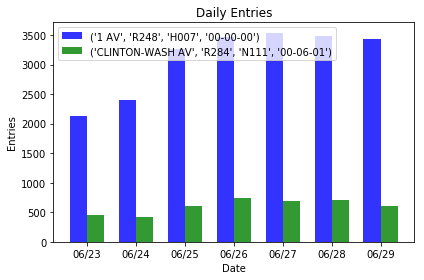

In [34]:
labels = [d.strftime("%m/%d") for d in df_td1['DATETIME']]

plt.figure(figsize = [20, 20])
fig, ax = plt.subplots()
index = np.arange(len(labels))
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, df_td1['DAILY_ENTRIES'], bar_width,
                 alpha=opacity,
                 color='b',
                 label=str(ts),
                tick_label=labels)

rects2 = plt.bar(index+bar_width, df_td2['DAILY_ENTRIES'], bar_width,
                alpha=opacity,
                color='g',
                label=str(ts),
                tick_label=labels)
 
plt.xlabel('Date')
plt.ylabel('Entries')
plt.title('Daily Entries')
plt.xticks(index + bar_width/2, labels)

plt.legend([str(ts1), str(ts2)])
 
plt.tight_layout()
plt.show()

## Question 5
Combine turnstiles for each Station/Unit/CA. 

In [106]:
df_last_ca = df_last.groupby(['STATION', 'UNIT', 'C/A', 'DATE']).sum().reset_index()
df_last_ca.head()

,STATION,UNIT,C/A,DATE,ENTRIES,EXITS,DAILY_ENTRIES
0,1 AV,R248,H007,06/23/2018,451300129,441476279,6966
1,1 AV,R248,H007,06/24/2018,451309173,441483395,7623
2,1 AV,R248,H007,06/25/2018,451320766,441491330,10259
3,1 AV,R248,H007,06/26/2018,451332896,441499456,10898
4,1 AV,R248,H007,06/27/2018,451345122,441507303,10797


In [108]:
df_last_ca.dtypes

STATION          object
UNIT             object
C/A              object
DATE             object
ENTRIES           int64
EXITS             int64
DAILY_ENTRIES     int64
dtype: object

## Question 6
Similarly, combine everything in each station, and come up with a time series of [(date1, count1),(date2,count2),...] type of time series for each STATION, by adding up all the turnstiles in a station.

In [113]:
df_last_st = df_last_ca.groupby(['STATION', 'DATE']).sum().reset_index()
df_last_st.head()

,STATION,DATE,ENTRIES,EXITS,DAILY_ENTRIES
0,1 AV,06/23/2018,3037831287,1625796990,13603
1,1 AV,06/24/2018,3037848773,1625816140,13664
2,1 AV,06/25/2018,3037868795,1625838295,16913
3,1 AV,06/26/2018,3037889792,1625861367,17616
4,1 AV,06/27/2018,3037910964,1625883912,17258


In [114]:
stations = df_last_st['STATION'].unique()
station_dict = {}
for station in stations:
    counts = []
    d = df_last_st[df_last_st['STATION'] == station]
    counts.append([(row['DATE'], row['DAILY_ENTRIES']) for index, row in d.iterrows()])
    station_dict[station] = counts

## Question 7
Plot time series.

<Figure size 1440x1440 with 0 Axes>

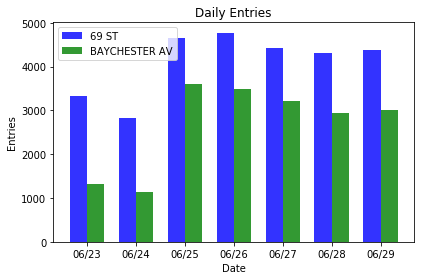

In [122]:
st = random.sample(list(stations), 2)

df_s1 = df_last_st[df_last_st['STATION'] == st[0]]
df_s2 = df_last_st[df_last_st['STATION'] == st[1]]

labels = [d[:-5] for d in df_s1['DATE']]

plt.figure(figsize = [20, 20])
fig, ax = plt.subplots()
index = np.arange(len(labels))
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, df_s1['DAILY_ENTRIES'], bar_width,
                 alpha=opacity,
                 color='b',
                 label=st[0],
                tick_label=labels)

rects2 = plt.bar(index+bar_width, df_s2['DAILY_ENTRIES'], bar_width,
                alpha=opacity,
                color='g',
                label=st[1],
                tick_label=labels)
 
plt.xlabel('Date')
plt.ylabel('Entries')
plt.title('Daily Entries')
plt.xticks(index + bar_width/2, labels)

plt.legend(st)
 
plt.tight_layout()
plt.show()

## Question 8
Plot daily counts of a station separated by week. 

In [344]:
from collections import defaultdict

STATION = "BAYCHESTER AV"
MAX_PPL_PER_SEC = 1
MAX_TRAFFIC = MAX_PPL_PER_SEC * 60 * 60 * 4
VERBOSE = False

In [347]:
def station_dataframe(date):
    url = str.format("http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt", date)
    df = url_to_dataframe(url)
    return df[df['STATION'] == STATION]

df_dict = defaultdict()

for wk in ["180630", "180623", "180616", "180609"]:
    df_dict[wk] = station_dataframe(wk)


Reading http://web.mta.info/developers/data/nyct/turnstile/turnstile_180630.txt
Reading http://web.mta.info/developers/data/nyct/turnstile/turnstile_180623.txt
Reading http://web.mta.info/developers/data/nyct/turnstile/turnstile_180616.txt
Reading http://web.mta.info/developers/data/nyct/turnstile/turnstile_180609.txt


In [375]:
def plot(week, d):
    i = list(df_dict.keys()).index(week)
    rects1 = plt.bar(index+(bar_width*i), d['DELTA_ENTRY'], bar_width,
                     alpha=opacity, label='week',
                     color=plt.cm.get_cmap('summer', 5)(i), 
                     tick_label=d['DAY'])
    return rects1

def add_key_column(d):
    d['KEY'] = d['STATION'] + " " + d['C/A'] + " " + d['SCP']
    return d
    
def log_percent(before, after, msg):
    print("{0:.0%}".format((before-after)/before), msg)
    
def set_delta_entry_per_scp(df, deep_copy=True, clean_data=False):
    d = df.copy(deep=deep_copy)
    d['NEXT LINE KEY'] = d['KEY'].shift(-1)
    d['DELTA_ENTRY'] = np.where(d['NEXT LINE KEY'] == d['KEY'], d['ENTRIES'].shift(-1) - d['ENTRIES'], -1)
    before = len(d)
    d = d.dropna()
    after = len(d)
    
    # sanity checking
    if VERBOSE:
        log_percent(before, after, "of rows NaN")
        peak_4_hrs = d['DELTA_ENTRY'].max()
        print(peak_4_hrs, "=", peak_4_hrs/(4*60*60), "per second max")
        
    # clean suspicious sums
    if clean_data:
        if VERBOSE:
            print(d[(d['DELTA_ENTRY'] >= MAX_TRAFFIC) |
                   (d['DELTA_ENTRY'] < 0)][['DELTA_ENTRY', 'DATE', 'TIME', 'KEY', 'NEXT LINE KEY']])
        before = len(d)
        d = d[(d['DELTA_ENTRY'] < MAX_TRAFFIC) &
              (d['DELTA_ENTRY']>= 0)]
        after = len(d)
        log_percent(before, after, "of rows exceed bounds")
    return d
        
def aggregate_scp_per_station(df):
    d = df.groupby(['KEY', 'NEXT LINE KEY', 'STATION', 'DATE', 'TIME']).sum().reset_index()
    if VERBOSE:
        print(len(d['DELTA_ENTRY'] < 5), "rows of low traffic")
        print(d[d['DELTA_ENTRY'] < 5][['DATE', 'TIME', 'DELTA_ENTRY', 'KEY', 'NEXT LINE KEY']])
    return d

2% of rows exceed bounds
2% of rows exceed bounds
2% of rows exceed bounds
2% of rows exceed bounds


<Figure size 1440x1440 with 0 Axes>

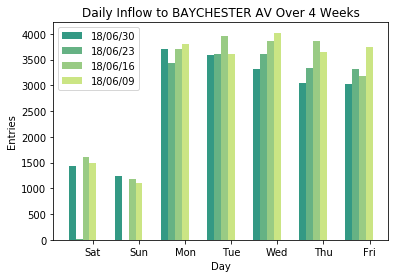

In [377]:
VERBOSE = False

plt.figure(figsize = [20, 20])
fig, ax = plt.subplots()
index = np.arange(7)
bar_width = 0.15
opacity = 0.8

plt.xlabel('Day')
plt.ylabel('Entries')
plt.title('Daily Inflow to ' + STATION + ' Over 4 Weeks')
plt.xticks(index, labels) 
    
for wk, df in df_dict.items():
    d = add_key_column(df)

    d = set_delta_entry_per_scp(d, deep_copy=True, clean_data=True)
    
    # combine unit, c/a, scp
    d = aggregate_scp_per_station(d)

    # combine delta entry per day to find daily total
    d = d.groupby(['DATE']).sum().reset_index()
    
    # convert date to weekday
    d['DAY'] = [pd.to_datetime(dt).day_name()[:3] for dt in d['DATE']]

    plot(wk, d)

plt.legend(["{}/{}/{}".format(wk[:2], wk[2:4], wk[-2:]) for wk in df_dict.keys()])


## Question 9
Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate.

In [329]:
wks = ["180630", "180623", "180616", "180609"]
mta_url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"

df_all_raw = pd.concat([url_to_dataframe(str.format(mta_url, wk)) for wk in wks])

Reading http://web.mta.info/developers/data/nyct/turnstile/turnstile_180630.txt
Reading http://web.mta.info/developers/data/nyct/turnstile/turnstile_180623.txt
Reading http://web.mta.info/developers/data/nyct/turnstile/turnstile_180616.txt
Reading http://web.mta.info/developers/data/nyct/turnstile/turnstile_180609.txt


In [ ]:
# add key
df_all = add_key_column(df_all_raw)

# find delta entry for each row
df_all = set_delta_entry_per_scp(df_all, clean_data=True)

# combine unit, c/a, scp
df_all = aggregate_scp_per_station(df_all)
    
# combine delta entry per day to find daily total
df_all = df_all.groupby(['STATION']).sum().reset_index()
    
df_all.sort_values(['DELTA_ENTRY'], ascending=False, inplace=True)

## Question 10
Make a single list of these total ridership values and plot it with
    
    plt.hist(total_ridership_counts)




(array([275.,  65.,  17.,   8.,   4.,   2.,   4.,   0.,   1.,   1.]),
 array([5.2200000e+02, 4.0287430e+05, 8.0522660e+05, 1.2075789e+06,
        1.6099312e+06, 2.0122835e+06, 2.4146358e+06, 2.8169881e+06,
        3.2193404e+06, 3.6216927e+06, 4.0240450e+06]),
 <a list of 10 Patch objects>)

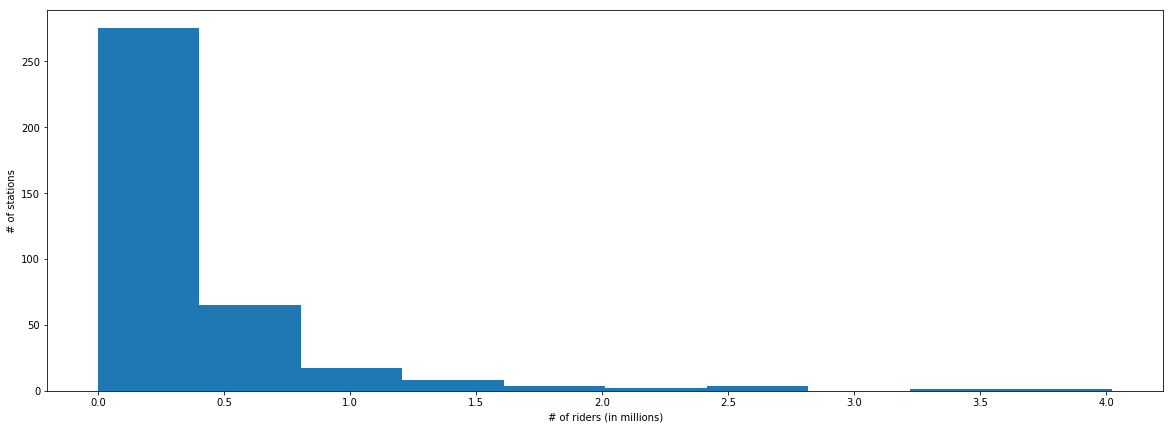

In [404]:
from matplotlib import ticker

total_ridership_counts = df_all['DELTA_ENTRY']
plt.figure(figsize = [20, 7])
ax = plt.subplot()
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: x/1000000))
plt.ylabel('# of stations')
plt.xlabel('# of riders (in millions)')
plt.hist(total_ridership_counts)

If you want to see which stations take the meat of the traffic, you can sort the total ridership counts and make a plt.bar graph. For this, you want to have two lists: the indices of each bar, and the values. The indices can just be 0,1,2,3,..., so you can do

    indices = range(len(total_ridership_values))
    plt.bar(indices, total_ridership_values)

<BarContainer object of 377 artists>

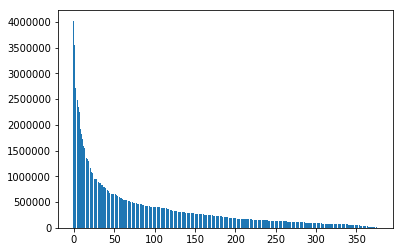

In [407]:
indices = range(len(total_ridership_counts))
plt.bar(indices, total_ridership_counts)

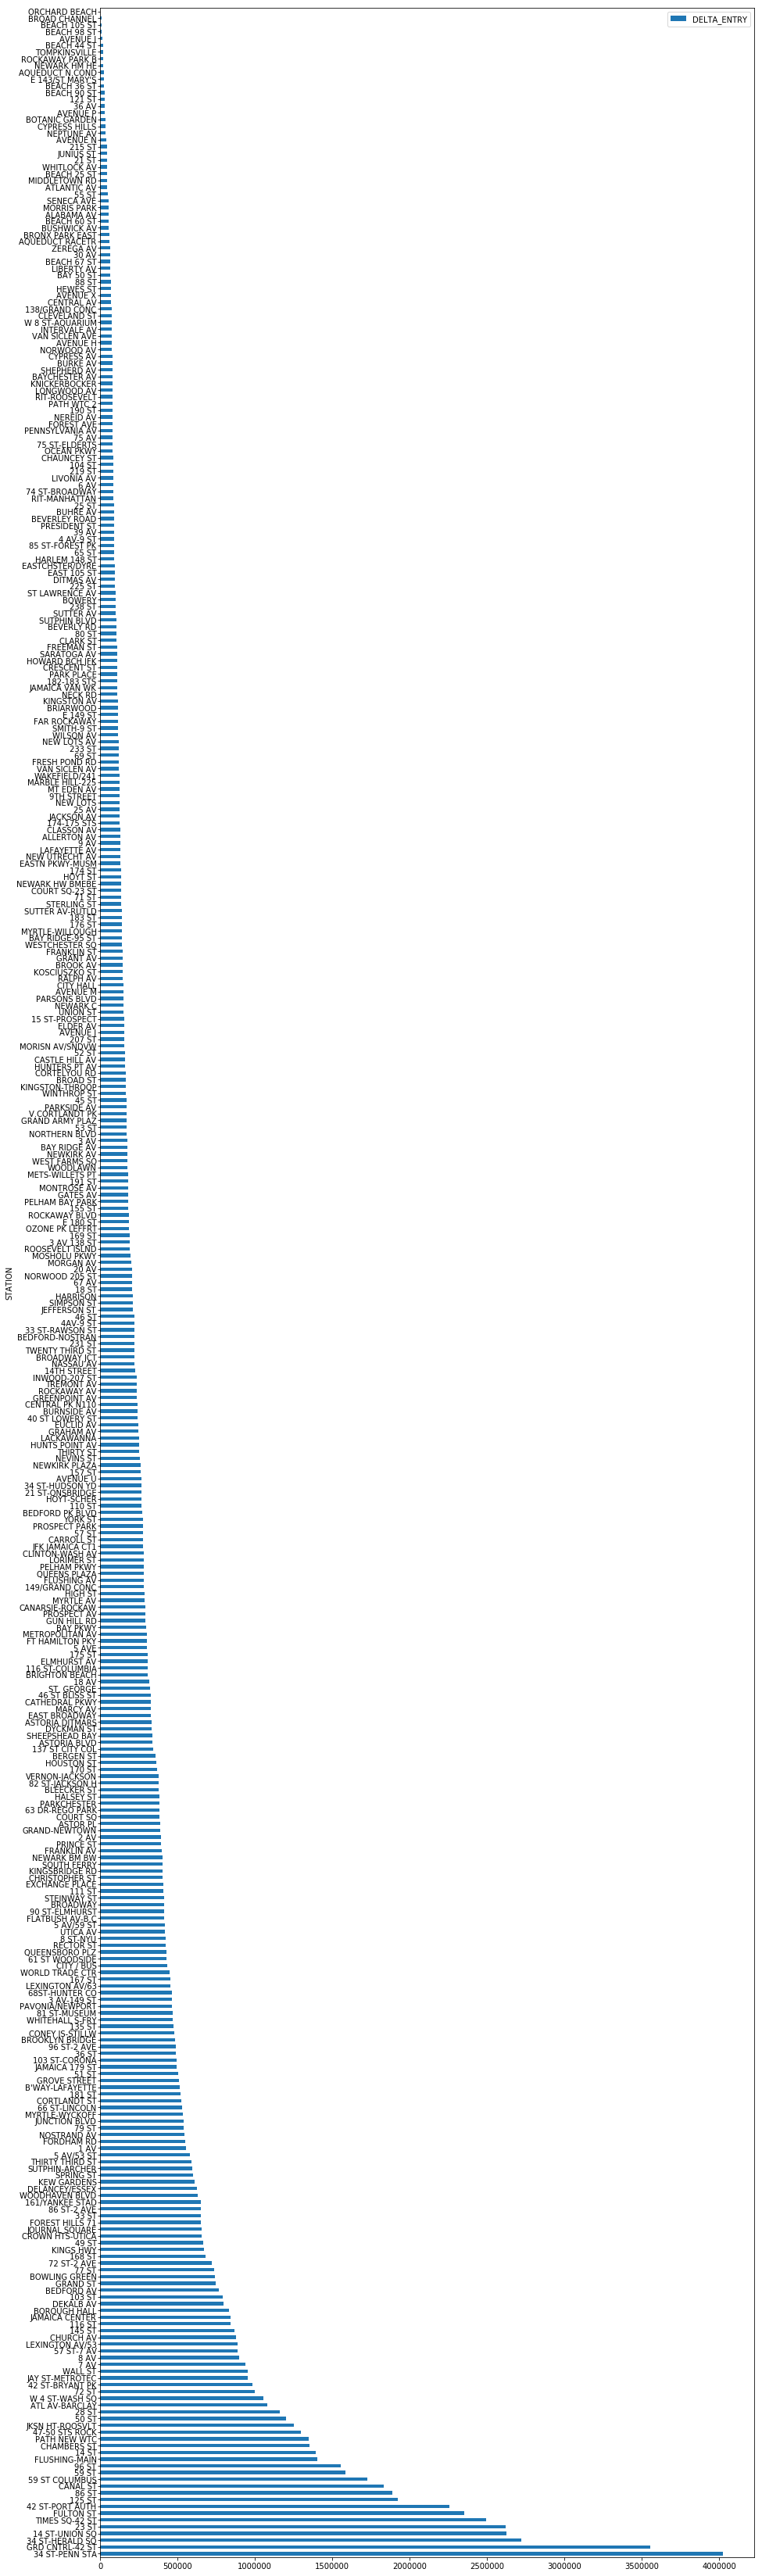

In [470]:
df_all[['STATION', 'DELTA_ENTRY']].plot.barh(
    x='STATION', 
    fontsize=10, 
    figsize=(15, 60), 
    rot=0)